# Preliminary Operations
## Imports

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
# import sys
from pathlib import Path
import scipy.io as sio
import imageio
import cv2




from IPython.display import HTML, display
import tabulate
import os
import warnings

# sys.path.append('../..');
from spyrit.learning.model_Had_DCAN import *
from spyrit.learning.nets import *
from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.reconstruction.recon_functions import * 


torch.manual_seed(19)

In [2]:
from scipy.sparse.linalg import aslinearoperator
import pylops

def TV(y, H, img_size, mu = 0.15, lamda = [0.1, 0.1], niter = 20, niterinner = 10):
    ny = img_size;
    nx = img_size;
    A = aslinearoperator(H);
    H_p = pylops.LinearOperator(A)
    Dop = \
        [pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                                kind='backward', dtype=np.float64),
         pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                                kind='backward', dtype=np.float64)]
    xinv, niter = \
    pylops.optimization.sparsity.SplitBregman(H_p, Dop, y.flatten(),
                                              niter, niterinner,
                                              mu=mu, epsRL1s=lamda,
                                              tol=1e-4, tau=1., show=False,
                                              **dict(iter_lim=5, damp=1e-4))
    return xinv;

def batch_TV(m, batch_size, ch, img_size, H,N_0, mu = 0.15, lamda = [0.001, 0.001], niter = 20, niterinner = 10):
    outputs = np.zeros((batch_size*ch, 1, img_size, img_size));
    M = H.shape[0];
    even_indices = range(0,2*M,2);
    uneven_index = range(1,2*M,2);
#     print(M)
    for i in range(batch_size*ch):
        m_i = torch2numpy(m[i,0,:]);
#         print(m_i.shape)
        m_i = m_i[even_indices]-m_i[uneven_index];
        out = TV(m_i, H, img_size, mu, lamda, niter, niterinner)
        outputs[i, 0, :,:] = 2/N_0*np.reshape(out, (img_size, img_size))-1;
    output_batch  = torch.Tensor(outputs);
    return output_batch;


## Parameters
### Acquisition Parameters

In [3]:
img_size = 64;

### Network and training

In [4]:
data_root = "../../data/" # Path to SLT-10 dataset
precompute_root ="../../models/SDCAN/"# Path to precomputed data
precompute =  False # Tells if the precomputed data is available 
n_iter = 5;

### Experimental Data

In [5]:
expe_root = "../../data/expe_2/" # Path to precomputed data

### Optimisation

In [6]:
num_epochs = 20 ; #Number of training epochs 
batch_size = 16; # Size of each training batch
reg = 1e-7; # Regularisation Parameter
lr = 1e-3; # Learning Rate
step_size = 4; #Scheduler Step Size
gamma =0.5; # Scheduler Decrease Rate

## Loading Pre-processed Data

In [7]:
my_average_file = Path(precompute_root) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file = Path(precompute_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

Path(precompute_root).mkdir(parents=True, exist_ok=True)
if not(my_average_file.is_file()) or not(my_cov_file.is_file()) or precompute:
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had, Cov_had = Stat_had(trainloader, precompute_root)
else:
    print('Loading covariance and mean')
    Mean_had = np.load(my_average_file)
    Cov_had  = np.load(my_cov_file)

if expe_root:
    my_transform_file = Path(expe_root) / ('transform_{}x{}'.format(img_size, img_size)+'.mat')
    H = sio.loadmat(my_transform_file);
    H = (1/img_size)*H["H"]

    my_average_file = Path(expe_root) / ('Average_{}x{}'.format(img_size, img_size)+'.mat')
    my_cov_file = Path(expe_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.mat')
    Mean_had_1 = sio.loadmat(my_average_file)
    Cov_had_1  = sio.loadmat(my_cov_file)

    Mean_had_1 = Mean_had_1["mu"]-np.dot(H, np.ones((img_size**2,1)));
    Mean_had_1 = np.reshape(Mean_had_1,(img_size, img_size));
    Mean_had_1 = np.amax(Mean_had)/np.amax(Mean_had_1)*Mean_had_1;
    Cov_had_1 = Cov_had_1["C"];
    Cov_had_1 = np.amax(Cov_had)/np.amax(Cov_had_1)*Cov_had_1;
    Cov_had = Cov_had_1;
    Mean_had = Mean_had_1;

else :
    H = None;
    
Var = Cov2Var(Cov_had_1)
Perm = Permutation_Matrix(Var)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Loading covariance and mean


In [8]:
Cov_had[0,0]

204.14419953787248

# Experimental Data (CR = 7/8)

In [9]:
def read_mat_data_index(expe_data, nflip, lambda_i = 548):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    lambda_indices = np.where(np.abs(F_spectro-lambda_i)<1);
    num_channel = lambda_indices[0][0];
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_pos = F_data_pos[:,:,num_channel];
    F_neg = F_data_neg[:,:,num_channel];
    if (2**16-1 in F_pos) or (2**16-1 in F_neg):
        warnings.warn("Warning, Saturation!", UserWarning)
    F_pos = F_pos.astype("int64");
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;


def read_mat_data(expe_data, nflip, lambda_min = 460, lambda_max = 700):
    F_pos = sio.loadmat(expe_data+"_{}_100_pos_data.mat".format(nflip));
    F_neg = sio.loadmat(expe_data+"_{}_100_neg_data.mat".format(nflip));
    F_data_pos = F_pos["F_WT_lambda_pos"];
    F_data_neg = F_neg["F_WT_lambda_neg"];
    F_spectro = F_pos["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F_pos = F_data_pos[:,:,F_spectro>lambda_min];
    F_neg = F_data_neg[:,:,F_spectro>lambda_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F_pos = F_pos[:,:,F_spectro<lambda_max];
    F_neg = F_neg[:,:,F_spectro<lambda_max];
    F_pos = np.sum(F_pos, axis=2);
    F_pos = F_pos.astype("int64");
    F_neg = np.sum(F_neg, axis=2);
    F_neg = F_neg.astype("int64");
    return F_pos, F_neg;

def read_mat_data_proc(expe_data, nflipi, lamda_min=460, lambda_max = 700):
    F = sio.loadmat(expe_data+"_{}_100_data.mat".format(nflip));
    F_data = F["F_WT_lambda"];
    F_spectro = F["spec"][0][0][0];
    F_spectro = F_spectro[0,:];
    F = F_data[:,:,F_spectro>lamdba_min];
    F_spectro = F_spectro[F_spectro>lambda_min];
    F = F[:,:,F_spectro<lambda_max];
    F = np.sum(F , axis=2);
    return F;

def load_data_list_index(expe_data,nflip, CR, K, Perm, img_size, num_channel = 548):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        F_pos = K*F_pos;
        F_neg = K*F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list

def load_data_list(expe_data,nflip, CR, K, Perm, img_size, lambda_min = 460, lambda_max = 700):
    even_index = range(0,2*CR,2);
    odd_index = range(1,2*CR,2);
    m_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        F_pos = 1/K*F_pos;
        F_neg = 1/K*F_neg;    
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        f_re_pos = np.dot(Perm, f_pos);
        f_re_neg = np.dot(Perm, f_neg);
        m = np.zeros((2*CR,1));
        m[even_index] = f_re_pos[:CR];
        m[odd_index] = f_re_neg[:CR];
        m = torch.Tensor(m);
        m = m.view(1,1,2*CR);
        m = m.to(device);
        m_list.append(m);
    return m_list
  
def ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def raw_ground_truth_list_index(expe_data,nflip, H, img_size, num_channel=548):
    gt_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data_index(expe_data[i],nflip[i], num_channel);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        gt_list.append(Gt);
    return gt_list


def ground_truth_list(expe_data,nflip, H, img_size, lambda_min = 460, lambda_max = 700):
    gt_list = [];
    max_list = [];
    for i in range(len(nflip)):
        F_pos , F_neg = read_mat_data(expe_data[i],nflip[i], lambda_min, lambda_max);
        f_pos = np.reshape(F_pos, (img_size**2,1));
        f_neg = np.reshape(F_neg, (img_size**2,1));
        Gt = np.reshape((1/img_size)*np.dot(H, f_pos-f_neg), (img_size, img_size));
        max_list.append(np.amax(Gt)-np.amin(Gt));
        Gt = 2*(Gt-np.amin(Gt))/(np.amax(Gt)-np.amin(Gt))-1;
        gt_list.append(Gt);
    return gt_list, max_list

def net_list(img_size, CR, Mean_had, Cov_had,net_arch, N0_list, sig, denoise, H, suffix, model_root):
    net_type = ['c0mp', 'comp','pinv', 'free']
    list_nets = [];
    for N0 in N0_list:
        recon_type = "";
        if N0==0:
            train_type = ''
        else :
            train_type = '_N0_{:g}_sig_{:g}'.format(N0,sig)
            if denoise:
                recon_type+="_Denoi";
        #- training parameters
        title = model_root + 'NET_'+net_type[net_arch]+train_type+recon_type+suffix ;
        if N0==0:
            model = compNet(img_size, CR, Mean_had, Cov_had, net_arch, H)
        else:
            if denoise:
                model = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
            else:
                model = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H);
        model = model.to(device);
        load_net(title,model);
        list_nets.append(model);
    return list_nets;

def simulated_noisy_images(gt_list, max_list, K, H):
    gt_index = max_list.index(max(max_list));
    GT = gt_list[gt_index];
    N = GT.shape[0];
    H_pos = np.zeros(H.shape);
    H_neg = np.zeros(H.shape);
    H_pos[H>0] = N*H[H>0];
    H_neg[H<0] = -N*H[H<0];
    simu_list = [];
    for i in range(len(gt_list)):
        if i!=gt_index:
            f_noi = simulated_measurement(GT, max_list[i]/K, H_pos, H_neg, N, H)
        else:
            f_noi = GT;
        simu_list.append(f_noi)
    return simu_list


def simulated_measurement(GT, N0, H_pos, H_neg, N, H):
    f = N0*np.reshape(((GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))), (N**2,1));
    m_pos = np.dot(H_pos,f);
    m_neg = np.dot(H_neg,f);
    m_pos += np.multiply(np.sqrt(m_pos),np.random.normal(0,1,size = m_pos.shape));
    m_neg += np.multiply(np.sqrt(m_neg),np.random.normal(0,1,size = m_neg.shape));
    m_noi = m_pos-m_neg;
    f_noi = np.reshape((1/N)*np.dot(H, m_pos-m_neg), (N, N));
    f_noi = 2*(f_noi-np.amin(f_noi))/(np.amax(f_noi)-np.amin(f_noi))-1;
    return f_noi;


def normalize(Img, a, b):
    return (a-b)*(Img-np.amin(Img))/(np.amax(Img)-np.amin(Img))+b;




def batch_flipud(vid):
    outs = vid;
    for i in range(vid.shape[1]):
        outs[0,i,0,:,:] = np.flipud(vid[0,i,0,:,:]);
    return outs;


In [10]:
def Inverse_square_root(A):
    """returns A^{-1/2}.
    Warning : This is only intended to be used if A is positive definite.
    """ 
    D, U = np.linalg.eig(A);
    D = 1/D;
    D = np.sqrt(D);
    A_inv = np.dot(np.dot(np.transpose(U), D), U);
    return diag(A_inv);


def diag(y):
    """
    Generates a diagonal matrix from vector y
    """ 
    n = y.shape[0];
    D = np.zeros((n,n));
    D[np.diag_indices(n)] = np.reshape(y,(n,));
    return D;

def Diag(A):
    """Extracts the diagonal elements of A"""
    a,b = A.shape;
    n = min(a,b);
    d = np.reshape(A[np.diag_indices(n)], (n,1));
    return d;


In [11]:
def Tikhonov_regularisation(H, y, x_0, P, R):
    """
    Solves the inverse problem 
    y = H x+ n ,
    by minimising 
    || Hx-y ||^2_{R^{-1}} + ||x - x_0||_{P^{-1}} , 
    where R is the noise covariance matrix, and P is the data covariance matrix.
    """
    Pat = np.dot(P, np.transpose(H));
    K = np.linalg.inv(R+np.dot(H,Pat));
    K_k = np.dot(Pat, K);
    x_out = x_0 + np.dot(K_k,y-np.dot(H,x_0));
    return x_out

def EM_TV(y, H, Sigma_a, img_size, Sigma_i, Sigma_1_2 = None, mu = 0.001, lamda = [0.1, 0.1], EM_N_iter = 4, niter = 3, niterinner = 3):
    """
    Solves the inverse problem 
    y = H x+ n ,
    by minimising 
    || Hx-y ||^2_{Sigma_a^{-1}} + lambda[0] ||D_1 x||_1 + lambda[1] ||D_2 x||_1
    where Sigma_a is the noise covariance matrix, where D_1 is the matrix corresponding to the first derivative over x and D_2 is the first derivative over y.
    This is done by applying the EM algorithm.
    """
    x_inv = np.zeros((img_size**2,1));
    if Sigma_1_2 is None:
        Sigma_1_2 = Inverse_square_root(Sigma_i);
    OP_TV = Sigma_1_2;
    for i in range(EM_N_iter):
        x_inv = np.reshape(x_inv, (img_size**2,1));
        # print(x_inv.shape)
        # print(y.shape)
        x_inv = Tikhonov_regularisation(H, y, x_inv, Sigma_i, Sigma_a);
        # print(x_inv.shape)
        # print(np.dot(Sigma_1_2, x_inv).shape)
        # print(OP_TV.shape)
        x_inv = TV(np.dot(Sigma_1_2, x_inv), OP_TV, img_size, mu=mu, lamda = lamda, niter = niter, niterinner=niterinner);
    return x_inv


def batch_EM_TV(m, batch_size, ch, img_size, H, N_0, Sigma_i, Sigma_1_2 = None, mu = 0.1, lamda = [1, 1], EM_N_iter = 4, niter = 20, niterinner = 10):
    outputs = np.zeros((batch_size*ch, 1, img_size, img_size));
    M = H.shape[0];
    One = np.dot(H, np.ones((img_size**2,1)))
    even_indices = range(0,2*M,2);
    uneven_index = range(1,2*M,2);
    for i in range(batch_size*ch):
        m_i = torch2numpy(m[i,0,:]);
        y_k_pos = m_i[even_indices];
        y_k_neg = m_i[uneven_index];
        
        y_k_pos = np.reshape(y_k_pos, (M,1));
        y_k_neg = np.reshape(y_k_neg, (M,1));
        
        Sigma_a = diag((y_k_pos+y_k_neg)/(N0**2));
        y_k = y_k_pos-y_k_neg;
        y_k = 2/N_0*y_k - One;
        out = EM_TV(y_k, H, Sigma_a, img_size, Sigma_i, Sigma_1_2 = Sigma_1_2, mu = mu, lamda = lamda, EM_N_iter = EM_N_iter, niter = niter, niterinner = niterinner);
        outputs[i, 0, :,:] = np.reshape(out, (img_size, img_size))-1;
    output_batch  = torch.Tensor(outputs);
    return output_batch


## LED Lamp

### Experimental Parameters

In [12]:
CR = 512;
img_size = 64; # Height / width dimension
sig =0.5; # std maximum total number of photons
K =1.6; # Normalisation constant
C = 1070;
s = 55;

N0 = 50;
# sig = 0.5;

even_index = range(0,2*CR,2);
uneven_index = range(1,2*CR,2);

# Pmat = np.dot(Perm,H);
# H_k = Pmat[:CR,:];

H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];
Sigma_i = np.dot(np.transpose(H),np.dot(Cov_had,H))
Sigma_1_2 = Inverse_square_root(Sigma_i);


### Loading Networks

In [13]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 25
Model Loaded: ../../models/TCI/Unet/U_net_pinv_N0_10_sig_0_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d

In [14]:
net_arch = 2
model_root = '../../models/TCI/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 25
Model Loaded: ../../models/TCI/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [15]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-05"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False;
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 25
Model Loaded: ../../models/TCI/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-05


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, 

In [16]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = EM_net_unshared(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
denoi_4.N0 = N0;
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 50 +/- 25
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): EM_net_unshared(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Pconv): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
    (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
    (denoise_list): ModuleList(
      (0): Denoise_layer(in_features=512)
      (1): Denoise_layer(in_features=512)
      (2): Denoise_layer(in_features=512)
      (3): Denoise_layer(in_features=512)
    )
    (conv): ModuleList(
      (0): DConvNet(
        (convnet): Sequential(
          (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (relu1): ReLU()
          (BN1): BatchNorm2d(64, eps=1e-05, momentum=0

In [17]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_5 = DConvNet();
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 25
Model Loaded: ../../models/TCI/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5), str

In [18]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_6 = model_root+"EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_6 = DConvNet();
denoi_6 = EM_net(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
denoi_6.N0 = N0;
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 50 +/- 25
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): EM_net(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (c

### Loading Compressed Data

In [19]:
titles_expe = ["noObjectD_1_0.0_variance", "noObjectD_1_0.3_02_variance"]+\
              ["noObjectD_1_0.3_03_variance", "noObjectD_1_0.3_04_variance"]+\
              ["noObjectD_1_0.3_01_variance"]+\
              ["noObjectD_1_0.3_01_variance", "noObjectD_1_0.6_variance"]+\
              ["noObjectD_1_1.0_variance", "noObjectD_1_1.3_variance"]

# channel = 548;
channel = 500;

nflip = [1 for i in range(len(titles_expe))];
expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];

m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);


m_prim = [];
m_prim.append(sum(m_list[:4])+m_list[6]);
m_prim.append(sum(m_list[:2]));
m_prim.append(m_list[1]+m_list[2]);
m_prim.append(m_list[6]+m_list[8]);
m_prim = m_prim+m_list[7:];
m_list = m_prim;

### Loading Ground Truth

In [20]:
GT=raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600
GT_prim = [];
GT_prim.append(sum(GT[:4])+GT[6]);
GT_prim.append(sum(GT[:2]));
GT_prim.append(GT[1]+GT[2]);
GT_prim.append(GT[6]+GT[8]);
GT_prim = GT_prim+GT[7:];
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
#    GT = [((GT[i]-np.amin(GT[i]))/max_list[i]+1)/2 for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];

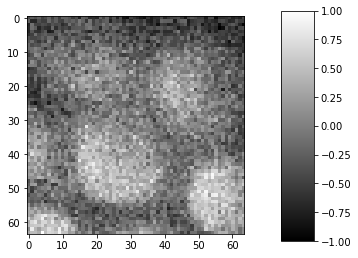

In [21]:
imagesc(GT[0])

In [22]:
cv2.imwrite('img/led_500.jpg', 127.5*(GT[0]+1))

True

In [23]:
print(max_list)

[42.5006103515625, 28.1329345703125, 21.94580078125, 9.949951171875, 7.39166259765625, 6.72607421875]


### Displaying Results

In [24]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]

titles = ["GT", "TV", "ConvNet", "U-Net", "modl", "neumann", "EM Shared", "EM Unshared"]

title_lists = [];
Additional_info = [[r"$\tilde{\alpha}$ ="+"{}".format(int(round(max_list[i]))) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];
with torch.no_grad():
    for i in range(len(GT)):
        list_outs = [];
        x_conv = model_5.forward_reconstruct_expe(1/K*m_list[i], 1, 1, img_size, img_size);
        x_U_net = model_1.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        x_Modl = model_2.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        x_neu = model_3.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        
        
        m = torch2numpy(m_list[i][0,0,even_index] - m_list[i][0,0,uneven_index]);
        alpha_est = np.amax(np.dot(np.dot(np.transpose(Pmat), np.linalg.inv(np.dot(Pmat, np.transpose(Pmat)))),m));
        model_4.recon.N0 = alpha_est;
        model_6.recon.N0 = alpha_est;
        x_EM_net_un = model_4.forward_reconstruct_expe(m_list[i],1,1, img_size, img_size, C, s, K);
        x_EM_net_s = model_6.forward_reconstruct_expe(m_list[i],1,1, img_size, img_size, C, s, K);  
        
        
        
        x_tv = batch_EM_TV(m_list[i], 1, 1, img_size, Pmat, alpha_est, Sigma_i, Sigma_1_2 = Sigma_1_2).to(device);
#         x_TV = batch_TV(m_list[i], 1, 1, img_size, H_k, alpha_est, mu = 1, lamda = [0.05, 0.05]).to(device);
       
        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);
#         list_outs.append(x_Pinv);
        list_outs.append(x_tv);
        list_outs.append(x_conv);
        list_outs.append(x_U_net);
        list_outs.append(x_Modl);
        list_outs.append(x_neu);
        list_outs.append(x_EM_net_s);
        list_outs.append(x_EM_net_un);
        for j in range(len(list_outs)-1):
            inp =  list_outs[j+1];
            #inp[inp>1.3] = 1.3;
            #inp[inp<-1.3] = -1.3;
            list_outs[j+1]= inp;
        output = torch.stack(list_outs, axis = 1);

        psnr_ = batch_psnr_vid(Ground_truth, output);
        ssim_ = batch_ssim_vid(Ground_truth, output);
        outputs.append(torch2numpy(output));
        title_lists.append(["{} {} \n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr_[j],2)) for j in range(len(titles))]);
    



In [25]:
nb_disp_frames =8;
o1 = outputs;
t1 = title_lists;
#compare_video_frames(outputs, nb_disp_frames, title_lists);
outputs_0 = outputs[:1];
outputs_1 = outputs[1:4];
outputs_2 = outputs[4:];
title_lists_0 = title_lists[:1];
title_lists_1 = title_lists[1:4];
title_lists_2 = title_lists[4:];

# compare_video_frames(outputs_0, nb_disp_frames, title_lists_0);
# compare_video_frames(outputs_1, nb_disp_frames, title_lists_1);
# compare_video_frames(outputs_2, nb_disp_frames, title_lists_2);

In [26]:
Additional_info[0][6]

''

## STL - 10 Cat
### Loading Compressed Data

In [27]:
titles_expe = ["stl10_05_1.5_0.0_0{}_variance".format(i) for i in range(1,7)]+\
              ["stl10_05_1_0.3_variance", "stl10_05_1_0.6_variance"]

expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];
nflip = [1.5 for i in range(len(titles_expe))];
nflip[-2:] = [1 for i in range(len(nflip[-2:]))]
channel = 581;
m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);


m_prim = [];
m_prim = [];
m_prim.append(sum(m_list[:7]));
m_prim.append(m_list[0]+m_list[1]);
m_prim.append(m_list[2]);
m_prim = m_prim+m_list[-2:];
m_list = m_prim;

### Loading Ground Truth

In [28]:
GT=raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600
GT_prim = [];
GT_prim.append(sum(GT[:7]));
GT_prim.append(GT[0]+GT[1]);
GT_prim.append(GT[2]);
GT_prim = GT_prim+GT[-2:];
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
#    GT = [((GT[i]-np.amin(GT[i]))/max_list[i]+1)/2 for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];

In [29]:
print(max_list)

[195.18157958984375, 74.08905029296875, 44.0924072265625, 17.8863525390625, 9.86907958984375]


### Displaying the results

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]

titles = ["GT", "TV", "ConvNet", "U-Net", "modl", "neumann", "EM Shared", "EM Unshared"]

title_lists = [];
Additional_info = [[r"$\tilde{\alpha}$ ="+"{}".format(int(round(max_list[i]))) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];
with torch.no_grad():
    for i in range(len(GT)):
#         print("i = {}".format(i))
        list_outs = [];
        x_conv = model_5.forward_reconstruct_expe(m_list[i], 1, 1, img_size, img_size);
        x_U_net = model_1.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        x_Modl = model_2.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        x_neu = model_3.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        
        m = torch2numpy(m_list[i][0,0,even_index] - m_list[i][0,0,uneven_index]);
        alpha_est = np.amax(np.dot(np.dot(np.transpose(Pmat), np.linalg.inv(np.dot(Pmat, np.transpose(Pmat)))),m));
        model_4.recon.N0 = alpha_est;
        model_6.recon.N0 = alpha_est;
        x_EM_net_un = model_4.forward_reconstruct_expe(m_list[i],1,1, img_size, img_size, C, s, K);
        x_EM_net_s = model_6.forward_reconstruct_expe(m_list[i],1,1, img_size, img_size, C, s, K);  
        
        
        
        # m = m_list[i][0,0,:].view(1,1,2*CR);
        x_tv = batch_EM_TV(m_list[i], 1, 1, img_size, Pmat, alpha_est, Sigma_i, Sigma_1_2 = Sigma_1_2).to(device);

        # x_tv = batch_EM_TV(m, 1, 1, img_size, Pmat, alpha_est, Sigma_i, Sigma_1_2 = Sigma_1_2).to(device);
#         x_TV = batch_TV(m_list[i], 1, 1, img_size, H_k, alpha_est, mu = 1, lamda = [0.05, 0.05]).to(device);

        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);
        list_outs.append(x_tv);
        list_outs.append(x_conv);
        list_outs.append(x_U_net);
        list_outs.append(x_Modl);
        list_outs.append(x_neu);
        list_outs.append(x_EM_net_s);
        list_outs.append(x_EM_net_un);

        for j in range(len(list_outs)-1):
            inp =  list_outs[j+1];
            #inp[inp>1.3] = 1.3;
            #inp[inp<-1.3] = -1.3;
            list_outs[j+1]= inp;
        output = torch.stack(list_outs, axis = 1);

        psnr_ = batch_psnr_vid(Ground_truth, output);
        ssim_ = batch_ssim_vid(Ground_truth, output);
        output = torch2numpy(output);
        output = batch_flipud(output);
        outputs.append(output);
#         for j in range(len(titles)):
#             print("j = {}".format(j))
#             print(titles[j])
#             print("[{}][{}]".format(i,j))
#             print(Additional_info[i][j])
#             print(psnr_[j])
        title_lists.append(["{} {} \n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr_[j],2)) for j in range(len(titles))]);
        
    
    


In [31]:
nb_disp_frames =8;
o2 = outputs;
t2 = title_lists;
#compare_video_frames(outputs, nb_disp_frames, title_lists);
outputs_0 = outputs[:1];
outputs_1 = outputs[1:4];
outputs_2 = outputs[4:];
title_lists_0 = title_lists[:1];
title_lists_1 = title_lists[1:4];
title_lists_2 = title_lists[4:];

# compare_video_frames(outputs_0, nb_disp_frames, title_lists_0);
# compare_video_frames(outputs_1, nb_disp_frames, title_lists_1);
# compare_video_frames(outputs_2, nb_disp_frames, title_lists_2);

## Star Sector (CR = 3/4)

In [32]:
# CR = 1024;
# img_size = 64; # Height / width dimension
# sig =0; # std maximum total number of photons
# K =1.6; # Normalisation constant
# C = 1070;
# s = 55;
# N0 = 50

# even_index = range(0,2*CR,2);
# uneven_index = range(1,2*CR,2);

# Pmat = np.dot(Perm,H);
# H_k = Pmat[:CR,:];
CR = 2048;
img_size = 64; # Height / width dimension
sig =0; # std maximum total number of photons
K =1.6; # Normalisation constant
C = 1070;
s = 55;
N0 = 50

even_index = range(0,2*CR,2);
uneven_index = range(1,2*CR,2);

# Pmat = np.dot(Perm,H);
# H_k = Pmat[:CR,:];

H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];
Sigma_i = np.dot(np.transpose(H),np.dot(Cov_had,H))
Sigma_1_2 = Inverse_square_root(Sigma_i);

In [33]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_2048_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 0
Model Loaded: ../../models/TCI/Unet/U_net_pinv_N0_10_sig_0_N_64_M_2048_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNo

In [34]:
net_arch = 2
model_root = '../../models/TCI/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_2048_epo_20_lr_0.001_sss_7_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 0
Model Loaded: ../../models/TCI/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_2048_epo_20_lr_0.001_sss_7_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [35]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_2048_epo_30_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False;
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 0
Model Loaded: ../../models/TCI/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_2048_epo_30_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride

In [36]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = EM_net_unshared(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
denoi_4.N0 = N0;
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; 
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 50 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_unshared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): EM_net_unshared(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Pconv): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
    (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (denoise_list): ModuleList(
      (0): Denoise_layer(in_features=2048)
      (1): Denoise_layer(in_features=2048)
      (2): Denoise_layer(in_features=2048)
      (3): Denoise_layer(in_features=2048)
    )
    (conv): ModuleList(
      (0): DConvNet(
        (convnet): Sequential(
          (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (relu1): ReLU()
          (BN1): BatchNorm2d(64, eps=1e-05, m

In [37]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_2048_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_5 = DConvNet();
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 50 +/- 0
Model Loaded: ../../models/TCI/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_2048_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5),

In [38]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_6 = model_root+"EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_6 = DConvNet();
denoi_6 = EM_net(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
denoi_6.N0 = N0;
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 50 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/EM_net_shared_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_2048_epo_22_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=2048, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=2048, out_features=4096, bias=False)
  (fc1): Linear(in_features=2048, out_features=4096, bias=False)
  (recon): EM_net(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

## Loading Experimental Data

In [39]:
titles_expe = ["starSectorD_2_0.0_01_variance", "starSectorD_2_0.0_02_variance"]+\
              ["starSectorD_2_0.0_03_variance", "starSectorD_2_0.0_04_variance"]+\
              ["starSectorD_2_0.0_05_variance", "starSectorD_2_0.0_06_variance"]+\
              ["starSectorD_2_0.0_07_variance", "starSectorD_2_0.0_08_variance"]+\
              ["starSectorD_2_0.0_09_variance", "starSectorD_2_0.0_variance"]+\
              ["starSectorD_2_0.3_variance", "starSectorD_2_0.6_variance"]+\
              ["starSectorD_2_1.0_variance", "starSectorD_2_1.3_variance"]

channel = 510;

nflip = [2 for i in range(len(titles_expe))];
expe_data = [expe_root+titles_expe[i] for i in range(len(titles_expe))];

m_list = load_data_list_index(expe_data, nflip, CR, K, Perm, img_size, num_channel = channel);
    
m_prim = [];
m_prim.append(sum(m_list[:10]));
m_prim.append(sum(m_list[7:9]));
m_prim = m_prim+m_list[9:-2];
m_list = m_prim;



## Loading GT

In [40]:
GT=raw_ground_truth_list_index(expe_data, nflip, H, img_size, num_channel = channel);
# Good values 450 - 530 -  548 - 600 -510

GT_prim = [];
GT_prim.append(sum(GT[:10]));
GT_prim.append(sum(GT[7:9]));
GT_prim = GT_prim+GT[9:-2];
GT = GT_prim;
max_list = [np.amax(GT[i])-np.amin(GT[i]) for i in range(len(GT))];
#    GT = [((GT[i]-np.amin(GT[i]))/max_list[i]+1)/2 for i in range(len(GT))];
GT = [((GT[i]-np.amin(GT[i]))/max_list[i])*2-1 for i in range(len(GT))];
max_list = [max_list[i]/K for i in range(len(max_list))];

In [41]:
print(max_list)

[295.0189208984375, 66.24908447265625, 39.9554443359375, 25.19775390625, 13.8604736328125]


In [42]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]

titles = ["GT", "TV", "ConvNet", "U-Net", "modl", "neumann", "EM Shared", "EM Unshared"]

title_lists = [];
Additional_info = [[r"$\tilde{\alpha}$ ="+"{}".format(int(round(max_list[i]))) if j==0 else "" for j in range(len(titles))] for i in range (len(max_list))]
Ground_truth = torch.Tensor(GT[0]).view(1,1,1,img_size, img_size).repeat(1,len(titles),1,1,1);
outputs = [];
with torch.no_grad():
    for i in range(len(GT)):
#         print("i = {}".format(i))
        list_outs = [];
        x_conv = model_5.forward_reconstruct_expe(1/K*m_list[i], 1, 1, img_size, img_size);
        x_U_net = model_1.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        x_Modl = model_2.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);
        x_neu = model_3.forward_reconstruct_expe(1/K*m_list[i],1,1, img_size, img_size);

        
        m = torch2numpy(m_list[i][0,0,even_index] - m_list[i][0,0,uneven_index]);
        alpha_est = np.amax(np.dot(np.dot(np.transpose(Pmat), np.linalg.inv(np.dot(Pmat, np.transpose(Pmat)))),m));
        
        model_4.recon.N0 = alpha_est;
        model_6.recon.N0 = alpha_est;
        x_EM_net_un = model_4.forward_reconstruct_expe(m_list[i],1,1, img_size, img_size, C, s, K);
        x_EM_net_s = model_6.forward_reconstruct_expe(m_list[i],1,1, img_size, img_size, C, s, K);        
        
        # x_tv = batch_TV(m_list[i], 1, 1, img_size, H_k, alpha_est, mu = 1, lamda = [0.05, 0.05]).to(device);
        # m = m_list[i][0,0,:].view(1,1,2*CR);
        # x_tv = batch_EM_TV(m, 1, 1, img_size, Pmat, alpha_est, Sigma_i, Sigma_1_2 = Sigma_1_2).to(device);
#         x_TV = batch_TV(m_list[i], 1, 1, img_size, H_k, alpha_est, mu = 1, lamda = [0.05, 0.05]).to(device);
        x_tv = batch_EM_TV(m_list[i], 1, 1, img_size, Pmat, alpha_est, Sigma_i, Sigma_1_2 = Sigma_1_2).to(device);

       
        gt = torch.Tensor(GT[i]).to(device);
        gt = gt.view(1,1, img_size, img_size);
        list_outs.append(gt);
        list_outs.append(x_tv);
        list_outs.append(x_conv);
        list_outs.append(x_U_net);
        list_outs.append(x_Modl);
        list_outs.append(x_neu);
        list_outs.append(x_EM_net_s);
        list_outs.append(x_EM_net_un);

        for j in range(len(list_outs)-1):
            inp =  list_outs[j+1];
            #inp[inp>1.3] = 1.3;
            #inp[inp<-1.3] = -1.3;
            list_outs[j+1]= inp;
        output = torch.stack(list_outs, axis = 1);

        psnr_ = batch_psnr_vid(Ground_truth, output);
        ssim_ = batch_ssim_vid(Ground_truth, output);
        output = torch2numpy(output);
#         output = batch_flipud(output);
        outputs.append(output);
#         for j in range(len(titles)):
#             print("j = {}".format(j))
#             print(titles[j])
#             print("[{}][{}]".format(i,j))
#             print(Additional_info[i][j])
#             print(psnr_[j])
        title_lists.append(["{} {} \n PSNR = {}".format(titles[j],Additional_info[i][j], round(psnr_[j],2)) for j in range(len(titles))]);

In [43]:
alpha_est

19.338284373283386

In [44]:
max_list[-1]

13.8604736328125

In [45]:
# %matplotlib inline
# plt.rcParams['figure.figsize'] = [30, 10]
nb_disp_frames =8;
o3 = outputs;
t3 = title_lists;
#compare_video_frames(outputs, nb_disp_frames, title_lists);
outputs_0 = outputs[:1];
outputs_1 = outputs[1:4];
outputs_2 = outputs[4:];
title_lists_0 = title_lists[:1];
title_lists_1 = title_lists[1:4];
title_lists_2 = title_lists[4:];

# compare_video_frames(outputs_0, nb_disp_frames, title_lists_0);
# compare_video_frames(outputs_1, nb_disp_frames, title_lists_1);
# compare_video_frames(outputs_2, nb_disp_frames, title_lists_2);

## Final Experimental image

In [52]:
out_lamp[:,a!=1,:,:,:]

array([[[[[-4.26162869e-01, -2.68637002e-01, -3.68460357e-01, ...,
           -6.34526730e-01, -7.25762188e-01, -4.38297927e-01],
          [-2.53112763e-01, -6.93435609e-01, -6.92674458e-01, ...,
           -3.51586163e-01, -5.31113148e-01, -5.13319850e-01],
          [-7.11616635e-01, -1.01719014e-01, -4.61591482e-01, ...,
           -4.30787116e-01, -7.23651171e-01, -9.56342518e-01],
          ...,
          [ 4.35526252e-01,  5.50658464e-01,  5.86546600e-01, ...,
            1.64950520e-01,  9.82723683e-02,  3.18814367e-01],
          [ 9.58453640e-02,  8.45647871e-01,  4.32840765e-01, ...,
            1.70738012e-01, -1.57425359e-01,  9.26141366e-02],
          [ 2.99254656e-01,  4.73094642e-01,  4.74344075e-01, ...,
            2.48230010e-01, -1.35079637e-01,  1.11312166e-01]]],


        [[[-1.31333089e+00, -1.32449818e+00, -1.43963885e+00, ...,
           -2.32278657e+00, -2.32610416e+00, -2.26740980e+00],
          [-1.32365572e+00, -1.33395529e+00, -1.60966599e+00, ...,
    

In [54]:
a = np.arange(0,9)
x = 1;

out_lamp = np.concatenate((np.reshape(o1[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o1[-3]), axis = 1)
title_lamp = [t1[0][0][:-11] + "(a)"]+t1[-3]

out_cat = np.concatenate((np.reshape(o2[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o2[-1]), axis = 1)
title_cat = [t2[0][0][:-11] + "(b)"]+t2[-1]

out_star = np.concatenate((np.reshape(o3[0][0,0,0,:,:],(1,1,1,img_size, img_size)), o3[-1]), axis = 1)
title_star = [t3[0][0][:-11] + "(c)"]+t3[-1]

# outputs = [out_lamp, out_cat, out_star]
# title_lists = [title_lamp, title_cat, title_star]
# mylist[:x] + mylist[x+1:]

outputs = [out_lamp[:,a!=x,:,:,:], out_cat[:,a!=x,:,:,:], out_star[:,a!=x,:,:,:]]
title_lists = [title_lamp[:x]+title_lamp[x+1:], title_cat[:x]+title_cat[x+1:], title_star[:x]+title_star[x+1:]]

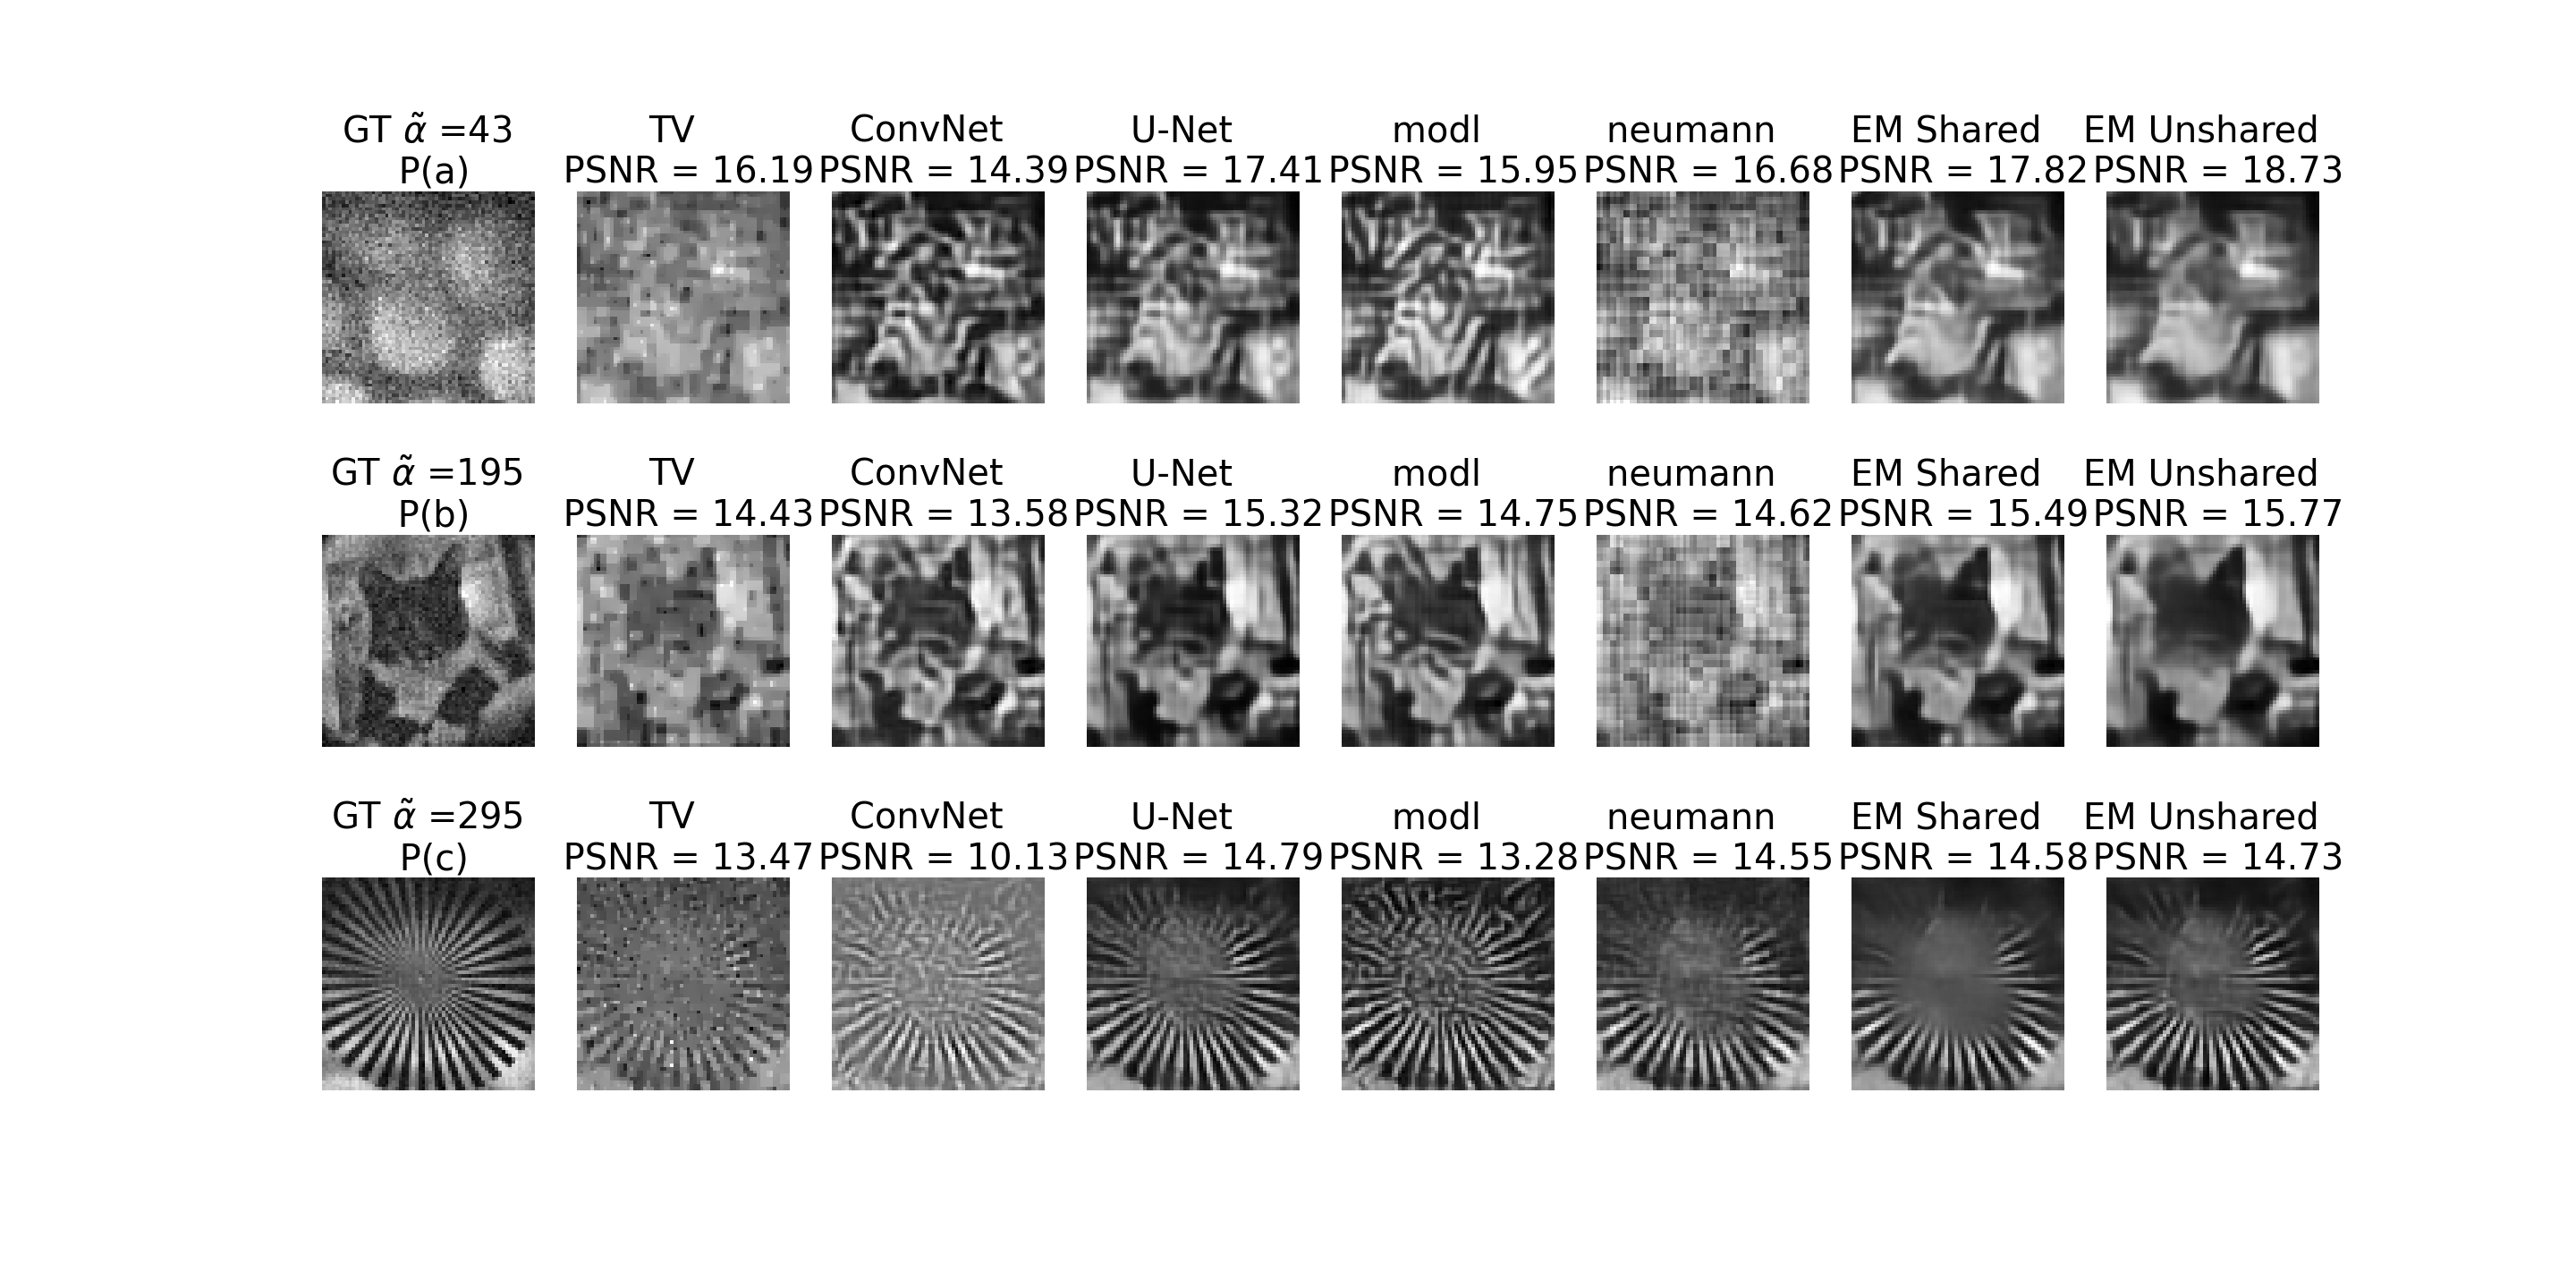

In [55]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['pdf.fonttype'] = 42
nb_disp_frames = 8
# compare_video_frames(outputs, nb_disp_frames, title_lists, aspect = (10,4) ,savefig = '../../img/isbi_2021/results_expe.pdf', fontsize = 12)
compare_video_frames(outputs, nb_disp_frames, title_lists, aspect = (40,20) ,savefig = '', fontsize = 40)

Image saved


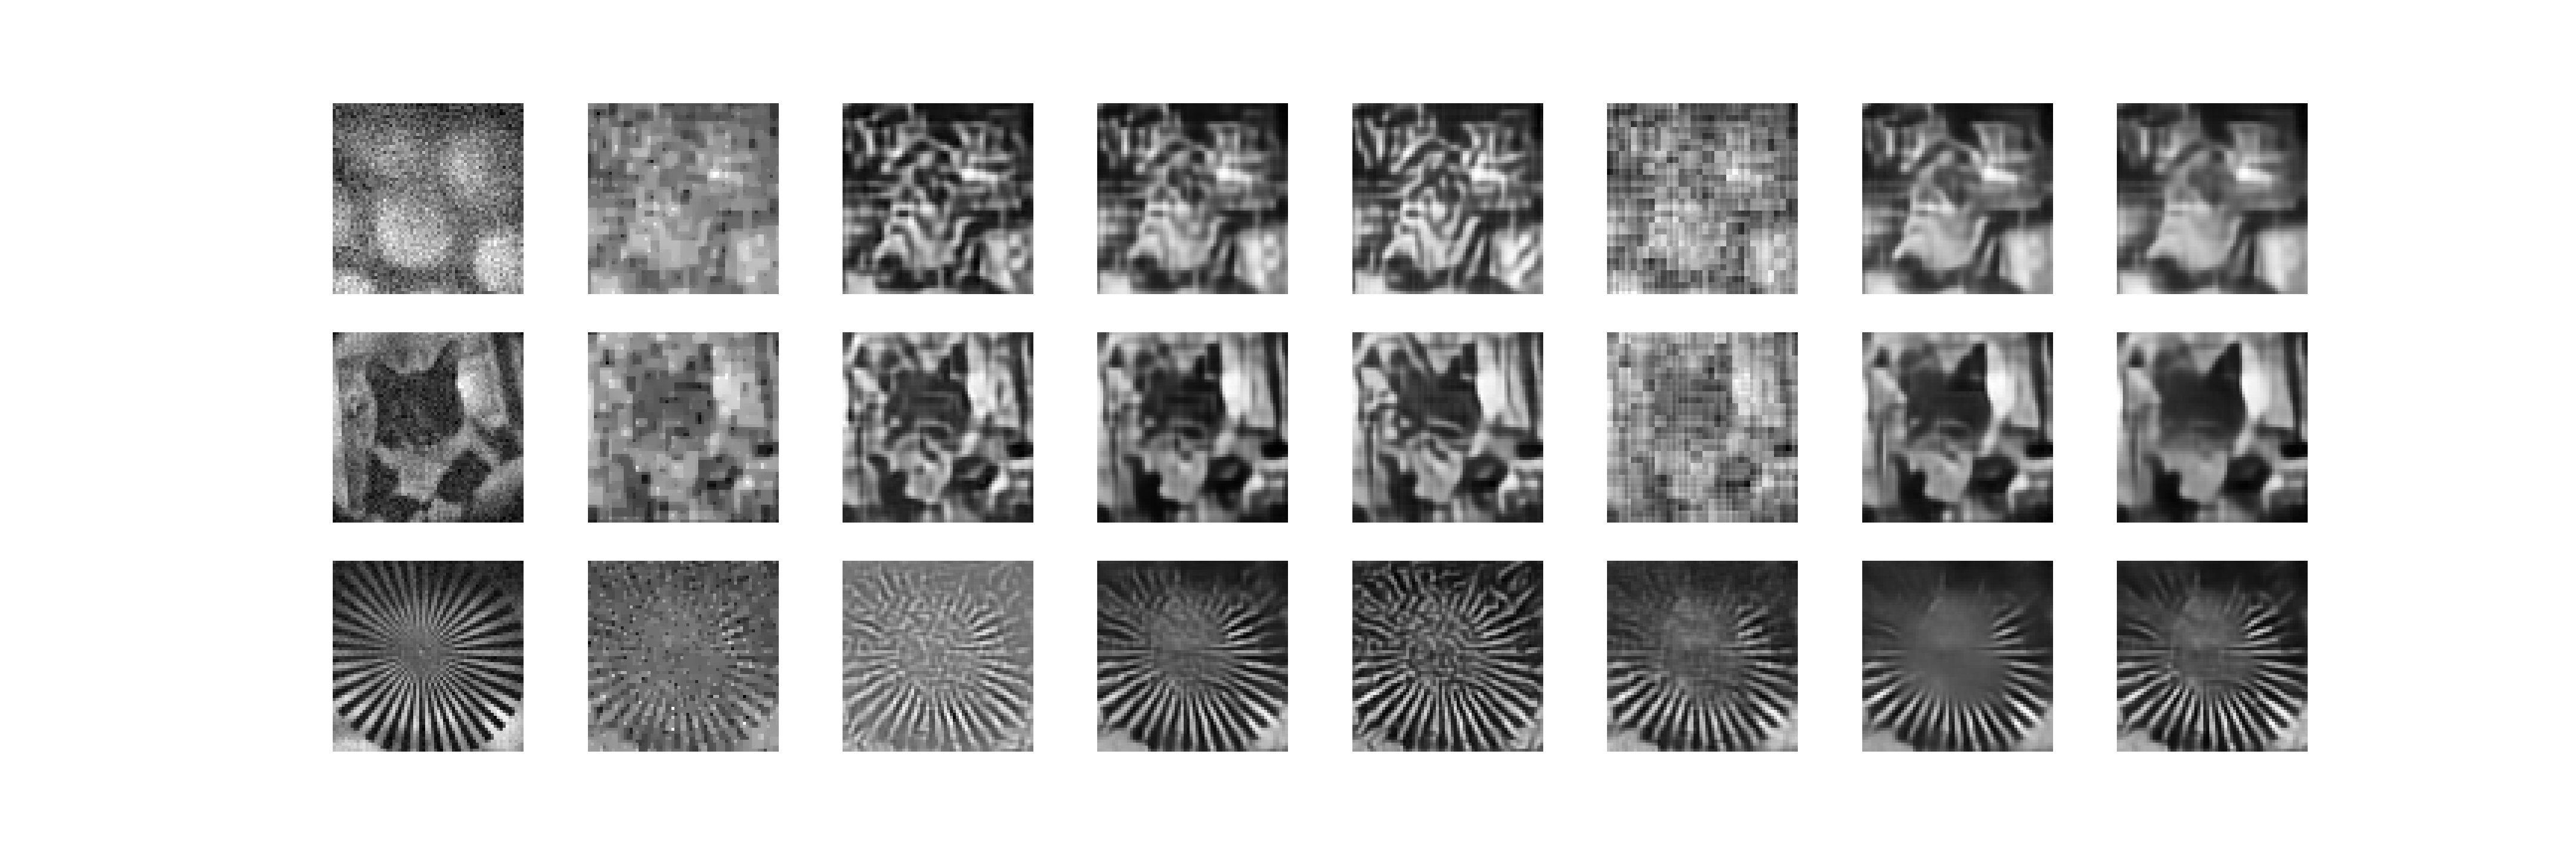

In [56]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['pdf.fonttype'] = 42
nb_disp_frames = 8
title_lists = [["" for i in range(9)] for j in range(3)]
compare_video_frames(outputs, nb_disp_frames, title_lists, aspect = (60,20) ,savefig = 'img/expe_images.pdf')